In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import re

def parse_oscilloscope_data(input_data):
    data = {
        'time_step': None,
        'voltage_step': None,
        'zero_level': None
    }
    
    patterns = {
        'time_step': r'Time step\s*=\s*([\d,]+)\s*([munpf]?)S',
        'voltage_step': r'Voltage step\s*=\s*([\d,]+)\s*([mun]?)V',
        'zero_level': r'Zero level\s*=\s*([\d,]+)'
    }
    
    unit_multipliers = {
        'n': 1e-9,
        'u': 1e-6,
        'm': 1e-3,
        'p': 1e-12,
        'f': 1e-15,
        '': 1
    }
        
    for line in input_data:
        line = line.strip()
        
        if match := re.search(patterns['time_step'], line, re.IGNORECASE):
            value = float(match.group(1).replace(',', '.'))
            unit = match.group(2).lower()
            data['time_step'] = value * unit_multipliers.get(unit, 1)
        
        elif match := re.search(patterns['voltage_step'], line, re.IGNORECASE):
            value = float(match.group(1).replace(',', '.'))
            unit = match.group(2).lower()
            data['voltage_step'] = value * unit_multipliers.get(unit, 1)
        
        elif match := re.search(patterns['zero_level'], line, re.IGNORECASE):
            value = float(match.group(1).replace(',', '.'))
            data['zero_level'] = value
    
    data["zero_level"] *= data['voltage_step']
    
    return data
        

In [ ]:
DIRECTORY = "Lab4_data"

FFT_N = 8192

def plot_osc_spec(name, lines, N, FFT_N, CLIP_FFT_N, markers=[], crop_markers_left=0, crop_markers_right=-1, delta_i=15):
    t = []
    x = []
    
    settings = parse_oscilloscope_data(lines[:5])        
    for line in lines:
        if len(line.split("\t")) < 3:
            continue
        try:
            t_i, x_i, _ = list(map(int, line.split("\t")))
        except:
            continue
        
        t.append(t_i * settings["time_step"])
        x.append(x_i)

    t = np.array(t)
    x = np.array(x)
    
    delta_f = 1 / (settings["time_step"] * FFT_N)
    print(settings["time_step"], delta_f)

    plt.figure(figsize=(16, 9))
    print(name)
    plt.xlabel("$t$, мкс")
    plt.ylabel("$U$, В")
    plt.plot(t[:N] * 1e6, x[:N], color="black")
    plt.show()
    
    window = np.array([(1 - np.cos(2 * np.pi * i / (len(x) - 1))) for i in range(len(x))])
    
    X = np.abs(np.fft.fft(x * window, FFT_N))

    X_db = 20 * np.log10(X)

    if len(markers) > 0:
        plt.figure(figsize=(16, 9))
        print(f"FFT with markers, {name}")
        plt.xlabel("$f$, МГц")
        plt.ylabel("$X$, дБ")
        for marker in markers:
            i = int(marker / delta_f * 1e6)
            
            print(crop_markers_left, crop_markers_right)
            
            interval = X_db[i - delta_i : i + delta_i]
            
            # print(delta_f, marker, i)
            print(f"marker: {marker}, max_freq: {(np.argmax(interval) + i - delta_i) * delta_f / 1e6}, max_val: {np.max(interval)}")
            print(f"marker: {marker}, min_freq: {(np.argmin(interval) + i - delta_i) * delta_f / 1e6}, min_val: {np.min(interval)}")
            # print(f"marker: {marker}, value: {np.min(X_db[i - delta_i : i + delta_i])} - {np.max(X_db[i - delta_i : i + delta_i])} дБ")
            plt.axvline(x=marker, color='red', linestyle='--', linewidth=2)
            plt.axvline(x=(i - delta_i) * delta_f / 1e6, color='lightgray', linestyle='--', linewidth=1)
            plt.axvline(x=(i + delta_i) * delta_f / 1e6, color='lightgray', linestyle='--', linewidth=1)
        crop_markers_left = int(crop_markers_left / delta_f * 1e6)
        crop_markers_right = int(crop_markers_right / delta_f * 1e6)
        plt.plot(np.arange(FFT_N)[crop_markers_left:crop_markers_right] * delta_f / 1e6, X_db[crop_markers_left:crop_markers_right
                                                                                                                         ])
        plt.show()
    
    X = np.abs(np.fft.fft(x, FFT_N))

    plt.figure(figsize=(16, 9))
    print(f"FFT, {name}")
    plt.xlabel("$f$, МГц")
    plt.ylabel("$X$, дБ")
    plt.plot(np.arange(FFT_N)[:CLIP_FFT_N] * delta_f / 1e6, X_db[:CLIP_FFT_N], color="black")
    plt.show()

for filename in os.listdir(DIRECTORY):
    if not filename.endswith('.txt'):
        continue
    filepath = os.path.join(DIRECTORY, filename)
    
    t = []
    x = []
    
    with open(filepath, "r") as f:
        lines = f.readlines()
        settings = parse_oscilloscope_data(lines[:5])        
        # plot_osc_spec(lines, 8000, 8192)

1e-08 12207.03125
1_3


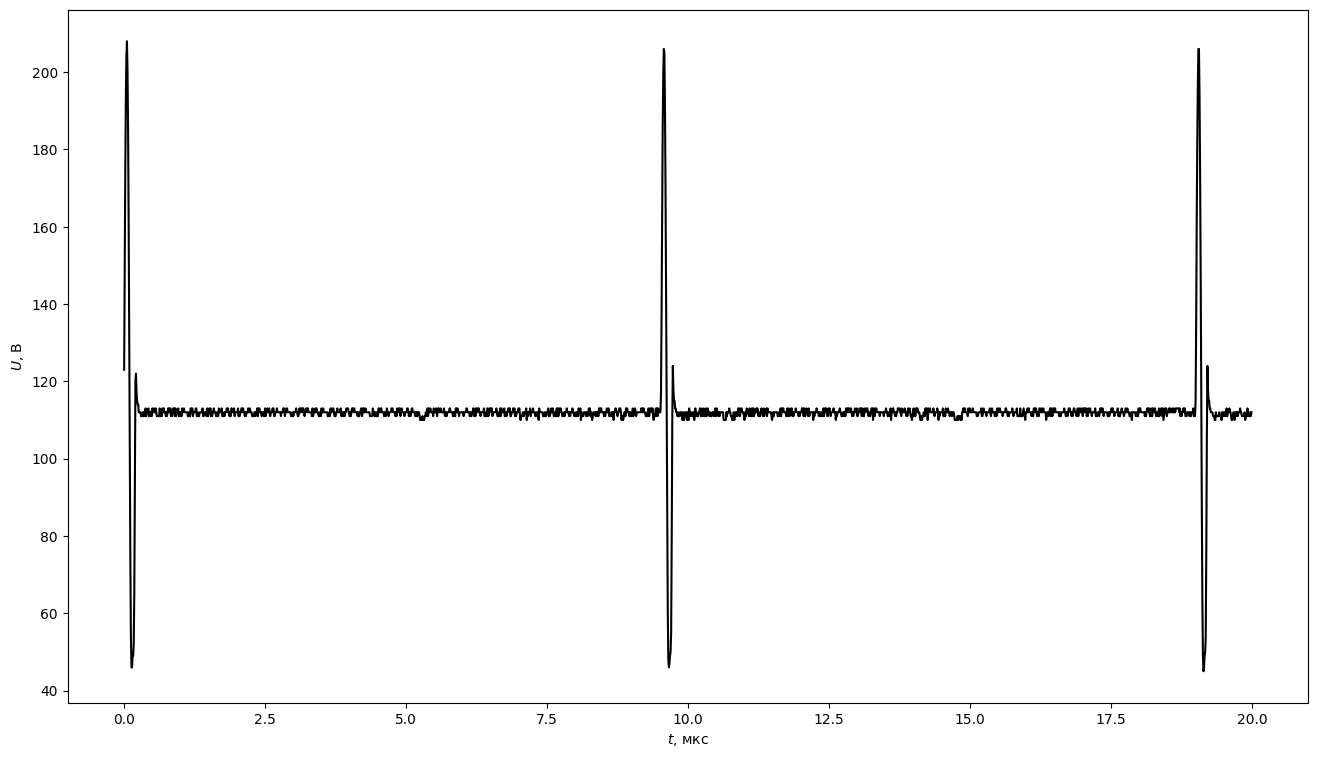

FFT with markers, 1_3
0 50
marker: 5, max_freq: 4.30908203125, max_val: 77.25796294831234
marker: 5, min_freq: 4.1748046875, min_val: 40.61204488024396
0 50
marker: 10, max_freq: 8.82568359375, max_val: 62.81280564223777
marker: 10, min_freq: 10.107421875, min_val: 23.00057686408917
0 50
marker: 12.5, max_freq: 11.767578125, max_val: 58.2769485012469
marker: 12.5, min_freq: 12.21923828125, min_val: 16.331368736406176
0 50
marker: 15, max_freq: 15.966796875, max_val: 55.23588534535901
marker: 15, min_freq: 14.55078125, min_val: 18.32378838652059
0 50
marker: 17.5, max_freq: 16.69921875, max_val: 55.14691102842786
marker: 17.5, min_freq: 17.2607421875, min_val: 30.021619450244383
0 50
marker: 20, max_freq: 20.69091796875, max_val: 49.08304141233977
marker: 20, min_freq: 20.849609375, min_val: 20.27208610101228


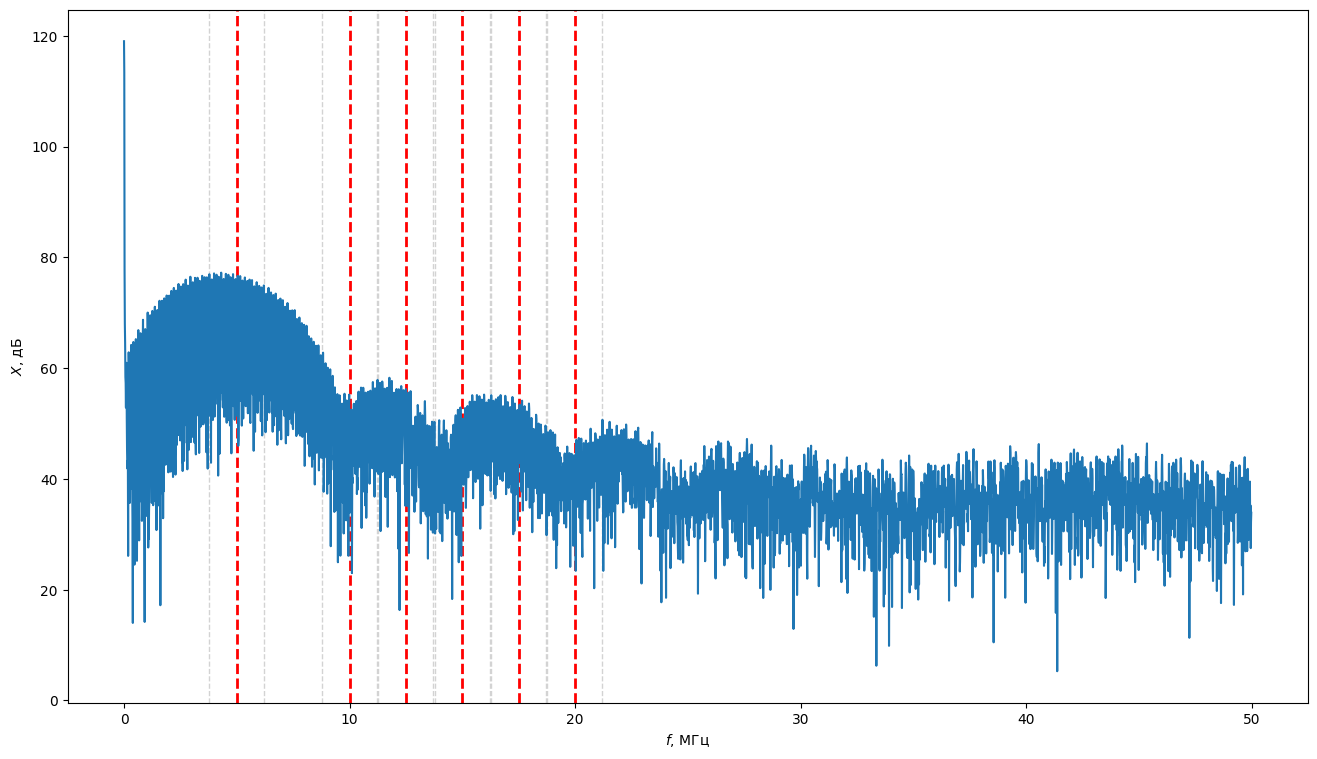

FFT, 1_3


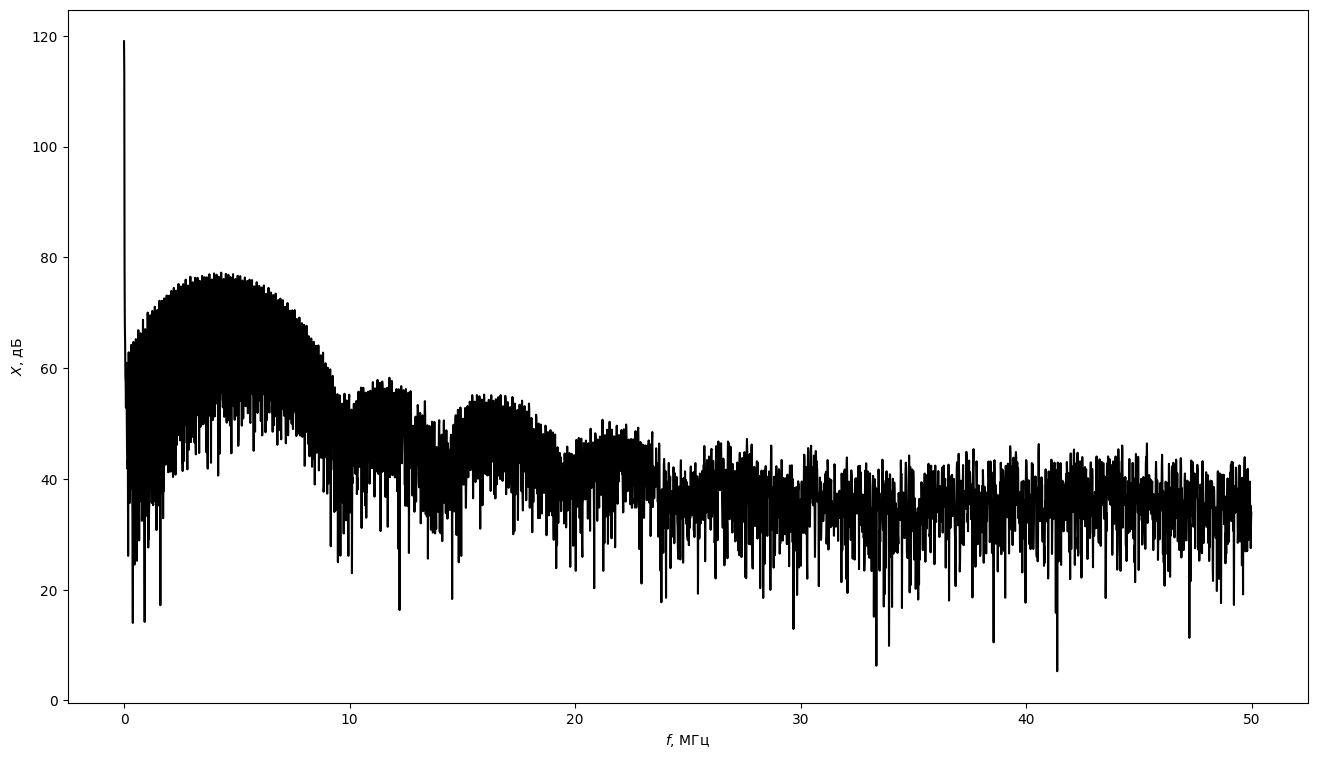

In [324]:
# with open("Lab4_data/1_1.txt", "r") as f:
#     markers = [2 / 3, 4 / 3, 2, 8 / 3, 10 / 3, 4]
#     plot_osc_spec("1_1", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=10, delta_i=50)

# with open("Lab4_data/1_2.txt", "r") as f:
#     markers = [1.5, 3, 5, 7.5, 8, 12.5]
#     plot_osc_spec("1_2", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=30, delta_i=50)

with open("Lab4_data/1_3.txt", "r") as f:
    markers = [5, 10, 12.5, 15, 17.5, 20]
    plot_osc_spec("1_3", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=50, delta_i=100)

In [ ]:
with open("Lab4_data/2_2.txt", "r") as f:
    markers = [11, 11.5, 12, 12.5, 13, 14, 17.5, 18, 18.5, 19]
    plot_osc_spec("2_2", f.readlines(), -1, 8192, 4096, markers, crop_markers_left=10, crop_markers_right=20)

In [ ]:
with open("Lab4_data/1_4_4.txt", "r") as f:
    markers = [1.9, 2.5, 3.2]
    plot_osc_spec("1_4_4", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=7)

with open("Lab4_data/1_4_2.txt", "r") as f:
    markers = [1.9, 2.5, 3.2]
    plot_osc_spec("1_4_2", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=7)

with open("Lab4_data/1_4_1.txt", "r") as f:
    markers = [1.9, 2.5, 3.2]
    plot_osc_spec("1_4_1", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=7)

1e-08 12207.03125
3_4


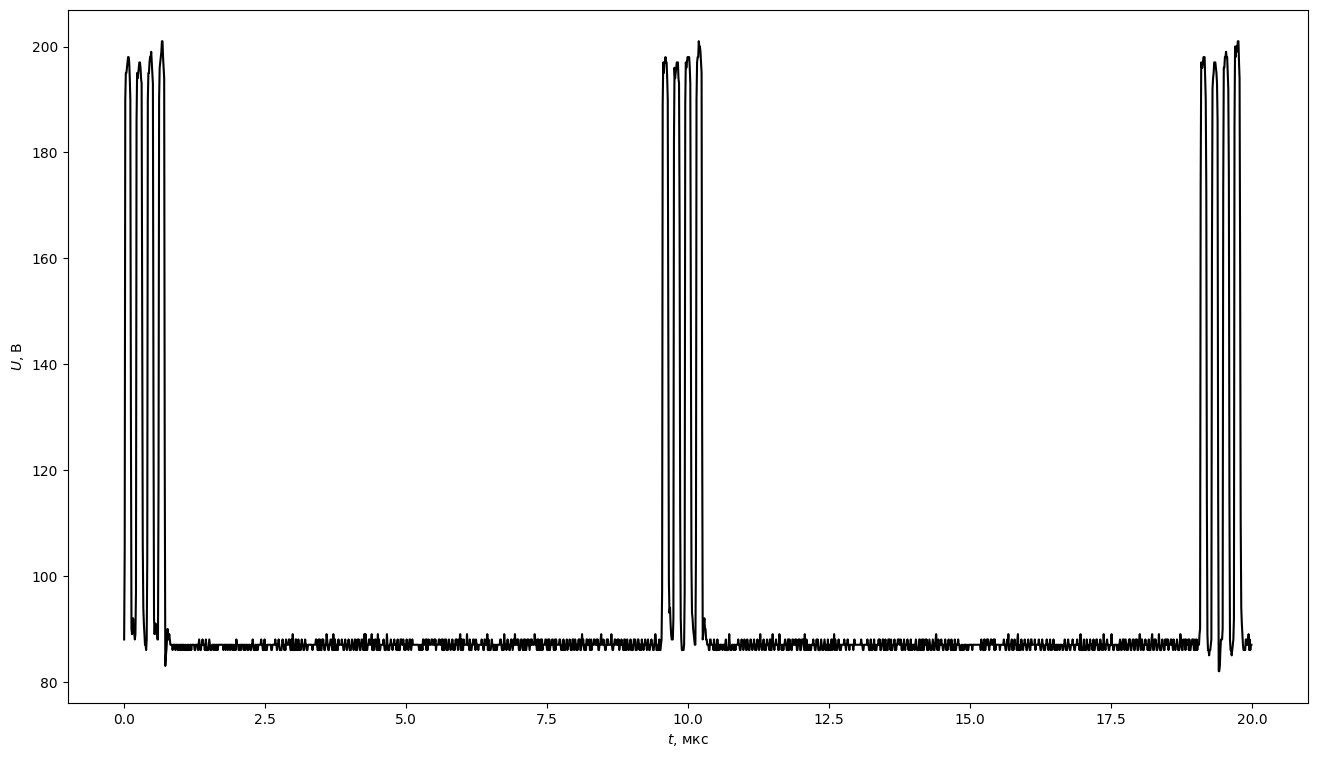

FFT with markers, 3_4
0 10
marker: 1.2, max_freq: 0.84228515625, max_val: 84.32582437357411
marker: 1.2, min_freq: 1.40380859375, min_val: 27.498325627288583
0 10
marker: 2, max_freq: 1.89208984375, max_val: 79.74266307181648
marker: 2, min_freq: 2.06298828125, min_val: 34.64699858490518
0 10
marker: 2.5, max_freq: 2.20947265625, max_val: 75.29932593375486
marker: 2.5, min_freq: 2.587890625, min_val: 16.726891473561587
0 10
marker: 3, max_freq: 3.25927734375, max_val: 78.51397921543717
marker: 3, min_freq: 2.77099609375, min_val: 34.638508356313935
0 10
marker: 3.5, max_freq: 3.25927734375, max_val: 78.51397921543717
marker: 3.5, min_freq: 3.84521484375, min_val: 23.413067003850493
0 10
marker: 5, max_freq: 4.833984375, max_val: 86.95879981986403
marker: 5, min_freq: 5.322265625, min_val: 43.09428469384636


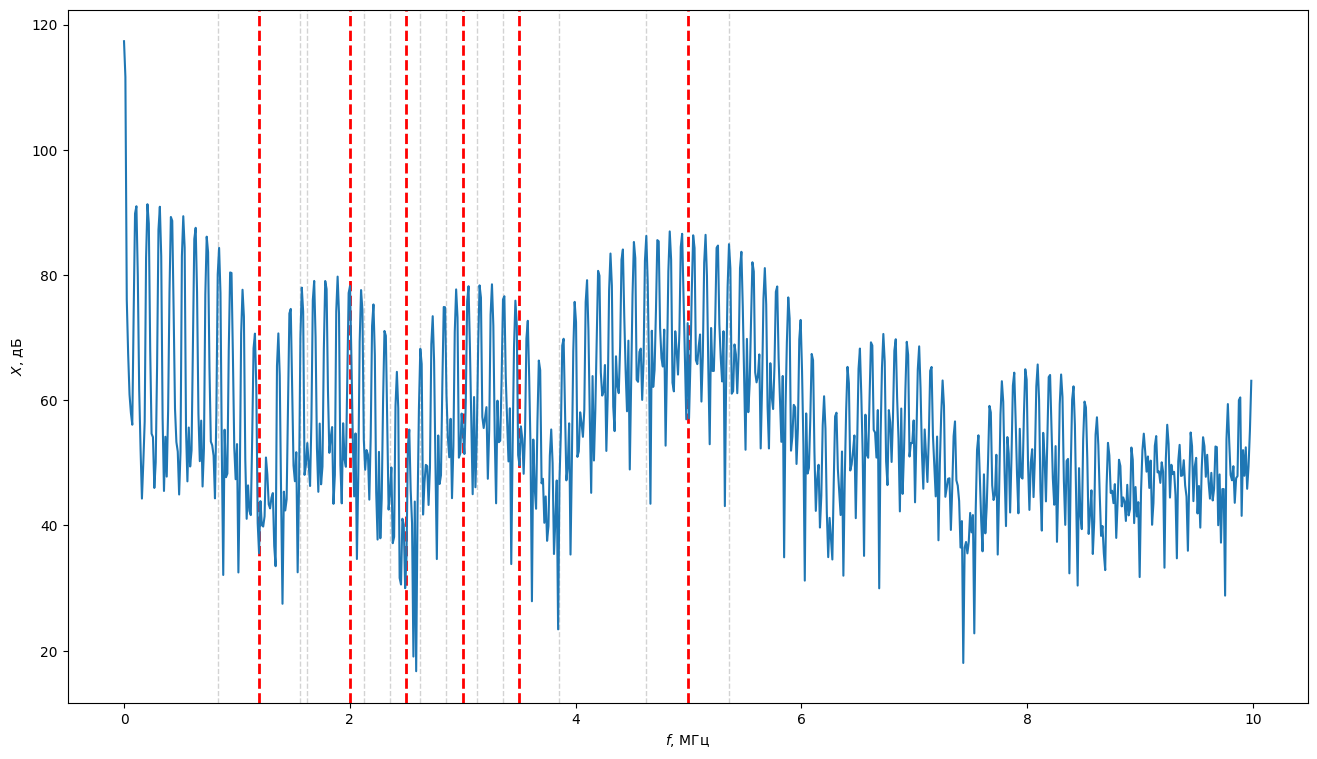

FFT, 3_4


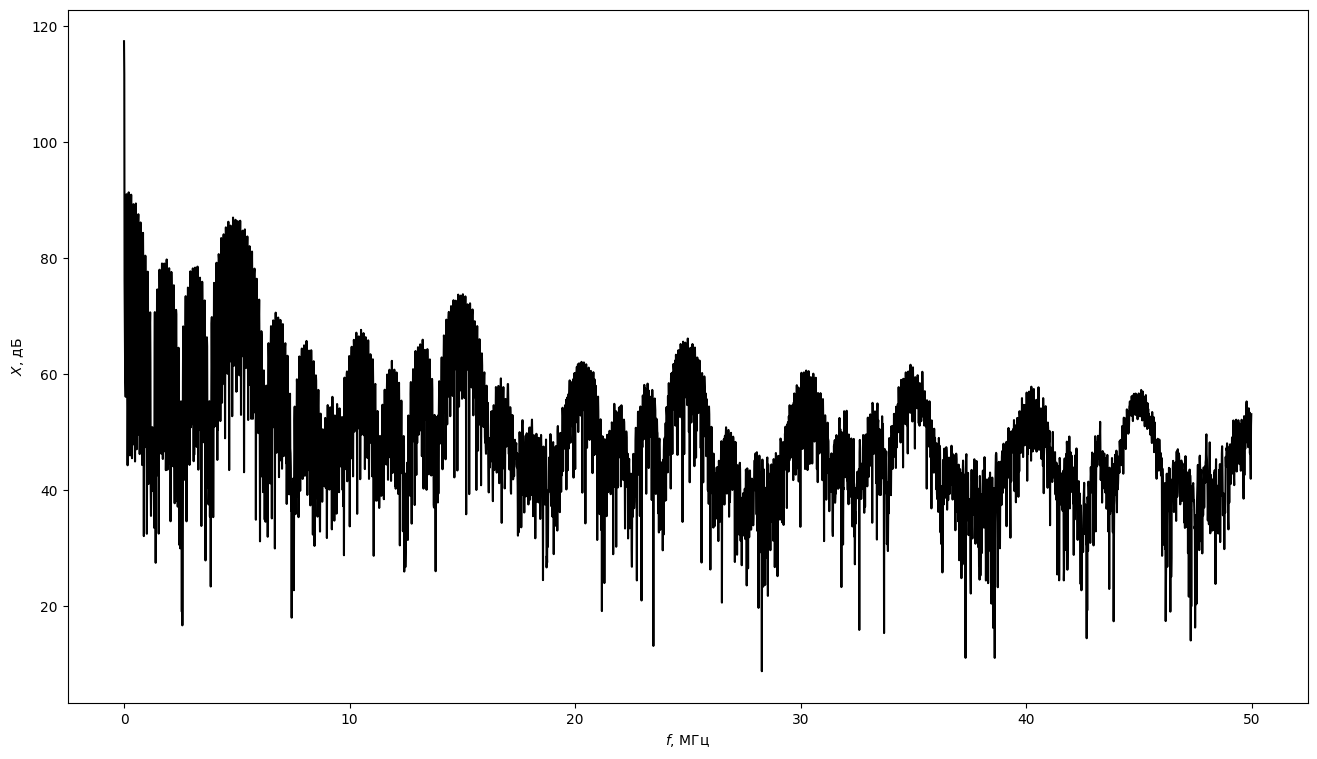

In [309]:
# with open("Lab4_data/3_1.txt", "r") as f:
#     markers = [2, 9, 13, 18, 22, 28]
#     plot_osc_spec("3_1", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=50, delta_i=100)

# with open("Lab4_data/3_2.txt", "r") as f:
#     markers = [3, 5, 7, 8.2, 9.3, 11]
#     plot_osc_spec("3_2", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=50, delta_i=80)

with open("Lab4_data/3_4.txt", "r") as f:
    markers = [1.2, 2, 2.5, 3, 3.5, 5]
    plot_osc_spec("3_4", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=10, delta_i=30)

4e-08 3051.7578125
2_3


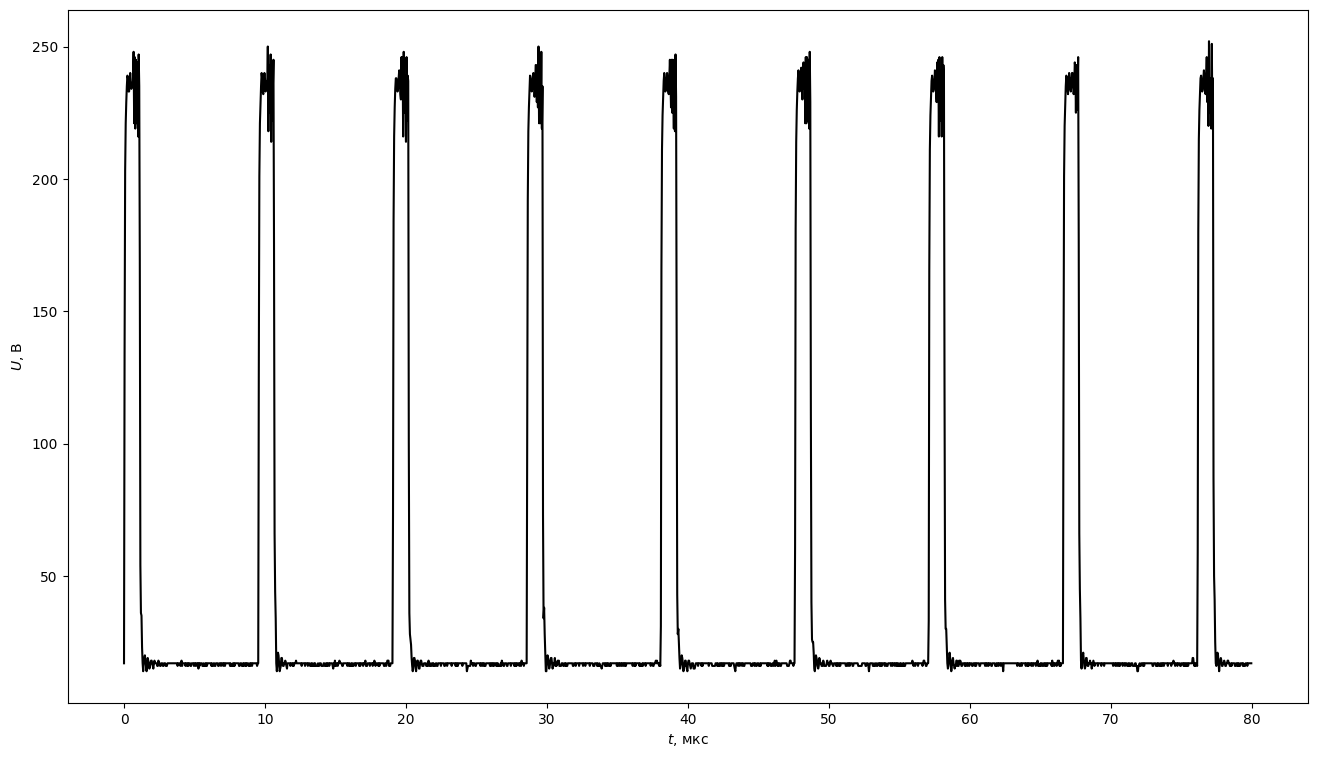

FFT, 2_3


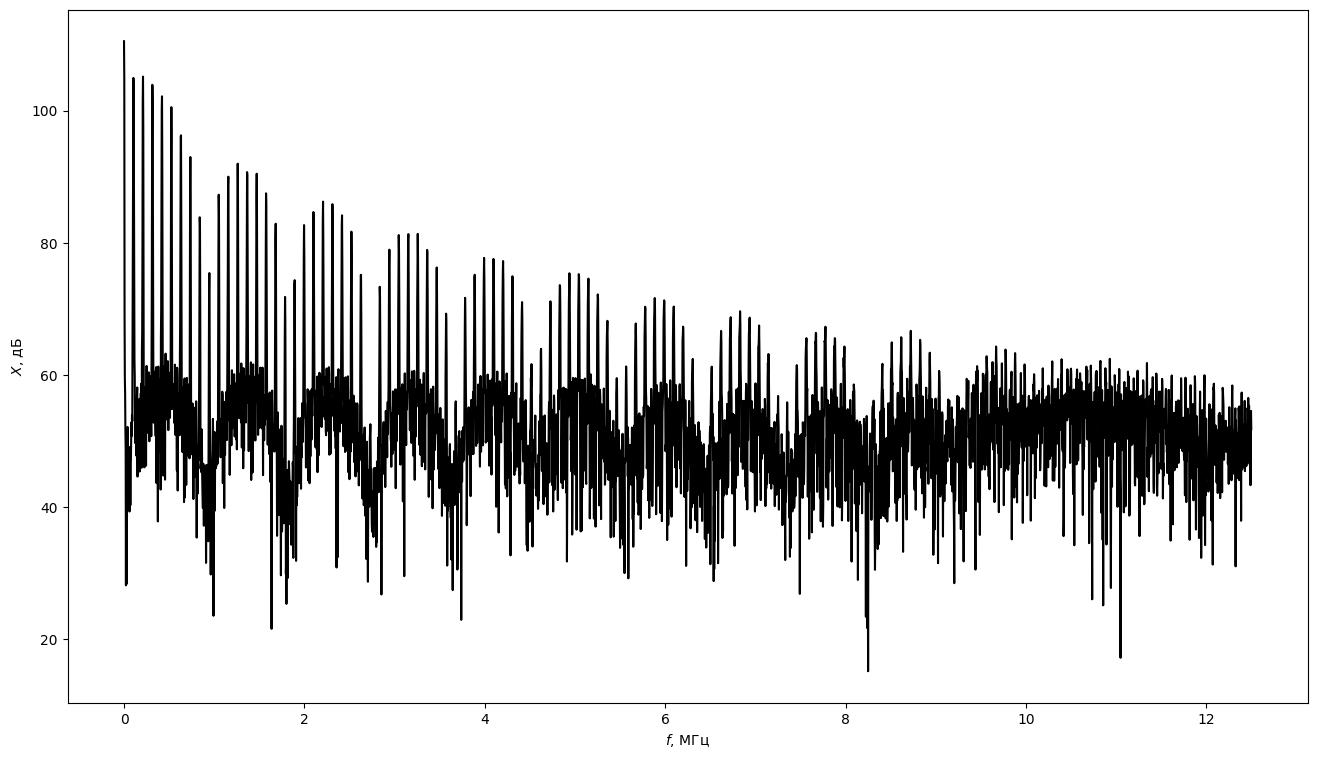

FileNotFoundError: [Errno 2] No such file or directory: 'Lab4_data/2_4.txt'

In [326]:
with open("Lab4_data/2_3.txt", "r") as f:
    markers = []
    plot_osc_spec("2_3", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=10, delta_i=30)

with open("Lab4_data/2_4.txt", "r") as f:
    markers = []
    plot_osc_spec("2_4", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=10, delta_i=30)

with open("Lab4_data/2_5.txt", "r") as f:
    markers = []
    plot_osc_spec("2_5", f.readlines(), 2000, 8192, 4096, markers, crop_markers_left=0, crop_markers_right=10, delta_i=30)
